In [2]:
#中译法案例分析
#用于正则化表达式
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import time 
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
#设备选择指定设备是否在GPU进行训练
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
#print(device)
#开始标志
SOS_token = 0
#结束标志
EOS_token = 1
#最大句子长度
MAX_LENGTH = 10
#数据路径
data_ptah = './eng-fra-v2.txt'

In [4]:
#数据文本清洗
def normalizeString(s):
    #小写化去除空格
    s = s.lower().strip()
    # 在.!?前加一个空格  这里的\1表示第一个分组   正则中的\num
    s = re.sub(r"([.!?])", r" \1", s)#sub替换  在标点符合前面加空格
    # s = re.sub(r"([.!?])", r" ", s)
    # 使用正则表达式将字符串中不是大小写字母和正常标点的都替换成空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
#读取文件获取样本并且获得英文和法文词典
def get_data():
    #读取文本数据
    with open('./eng-fra-v2.txt') as fr:
        sequences = fr.read().strip().split('\n')
    #print(len(sequences))
    #print(sequences[:2])
    #将一个样本中的英文和法文分开 同时处理并且标准化
    my_pairs = [[normalizeString(s) for s in sequence.split('\t')]for sequence in sequences]#为两维
    #print(my_pairs[:2])
    #构建词典
    english_word2index = {'SOS':0,'EOS':1}
    english_word_n = 2
    french_word2index = {'SOS':0,'EOS':1}
    french_word_n = 2
    #遍历列表构建英文法文字典
    for pair in my_pairs:
        for word in pair[0].split(' '):
            if word not in english_word2index.keys():
                english_word2index[word] = english_word_n
                english_word_n += 1
        for word in pair[1].split(' '):
            if word not in french_word2index.keys():
                french_word2index[word] = french_word_n
                french_word_n += 1
    #print(len(english_word2index))
    #print(len(french_word2index))
    #获取index2word
    english_index2word = {v:k for k,v in english_word2index.items()}
    french_index2word = {v:k for k,v in french_word2index.items()}
    #print(english_index2word)
    return english_word2index,english_index2word,english_word_n,french_word2index,french_index2word,french_word_n,my_pairs
#get_data()#输出元组
english_word2index,english_index2word,english_word_n,french_word2index,french_index2word,french_word_n,my_pairs = get_data()

In [6]:
#构建dataset数据源
class MypairDataset(Dataset):
    def __init__(self,my_pairs):
        super().__init__()
        self.my_pairs = my_pairs
        self.sample_len = len(my_pairs)
    def __len__(self):
        return self.sample_len
    def __getitem__(self,index):
        x = self.my_pairs[index][0]#取出英文
        y = self.my_pairs[index][1]#取出法文
        #样本xy数值化
        x = [english_word2index[word] for word in x.split(' ')]
        x.append(EOS_token)
        tensor_x = torch.tensor(x,dtype = torch.long, device = device)
        #print(tensor_x)
        
        y = [french_word2index[word] for word in y.split(' ')]
        y.append(EOS_token)
        tensor_y = torch.tensor(y,dtype = torch.long, device = device)
        return tensor_x,tensor_y

In [7]:
#dataset进行封装
def dm_test_MyPairsDataset():
    mypairdataset = MypairDataset(my_pairs)
    train_dataloader = DataLoader(
        dataset = mypairdataset,
        batch_size = 1,
        shuffle = True
    )
    return train_dataloader
#train_dataloader = dm_test_MyPairsDataset()
#for x,y in train_dataloader:
    #print(x)
    #print(y)
   # break

In [8]:
#dataad = MypairDataset(my_pairs)
#tensor_x,tensor_y = dataad[100]
#print(tensor_x)
#print(tensor_y)

In [9]:
#构建GRU的编码器
class EncoderGRU(nn.Module):
    def __init__(self,input_size,hidden_size):#input_size 代表英文单词的总个数（去重）
        super(EncoderGRU,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        #实例化embedding层
        self.embedding = nn.Embedding(input_size,hidden_size)
        #batch_first = True gru的输入是[batch_size,seq_len,embedding]
        self.gru = nn.GRU(hidden_size,hidden_size,batch_first = True)
    def forward(self,x,h0):
        #x来自于dataloder h0初始化的gru模型的隐藏层结果
        #x转化为三维张量
        embed_x = self.embedding(x)
        output,hn = self.gru(embed_x,h0)
        return output,hn
    def inithidden(self):
        return torch.zeros(1,1,self.hidden_size, device = device)
#train_dataloader = dm_test_MyPairsDataset()
#input_size = len(english_word2index)
#hidden_size = 256
#encoder = EncoderGRU(input_size,hidden_size).to(device)
#print(encoder)
#for x,y in train_dataloader:
    #h0 = encoder.inithidden()
    #output,hn = encoder(x,h0)
    #print(output.shape,hn.shape)
    #break

In [10]:
#构建解码器（不带attention的解码器）
class DecoderGRU(nn.Module):
    def __init__(self,output_size,hidden_size):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(output_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size,batch_first = True)
        self.out = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    def forward(self,input,hidden):
        output = self.embed(input)
        output = F.relu(output)
        output,hidden = self.gru(output,hidden)
        output = self.softmax(self.out(output[0]))
        return output,hidden
    def inithidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
def test():
    train_dataloader = dm_test_MyPairsDataset()
    input_size = len(english_word2index)
    hidden_size = 256
    encoder = EncoderGRU(input_size,hidden_size).to(device)
    
    output_size = french_word_n
    decoder = DecoderGRU(output_size,hidden_size).to(device)
    #将数据送入seq2seq
    
    for x,y in train_dataloader:
        h0 = encoder.inithidden()
        encoder_output,encoder_hidden = encoder(x,h0)
        #解码 一个词一个词去解码
        hidden = encoder_hidden
        for idx in range(y.shape[1]):
            temp_vector = y[0][idx].view(1,-1)
            output,hidden = decoder(temp_vector,hidden)
            print(output.shape)
            print(hidden.shape)  
        break
        
    #print(decoder)
#test()

In [11]:
##构建解码器（带attention的解码器）
class AttnDecoderGRU(nn.Module):
    def __init__(self,output_size,hidden_size,dropout_p = 0.1,max_length = MAX_LENGTH):
        super().__init__()
        self.output_size = output_size#法文单词的总个数
        self.hidden_size = hidden_size#词嵌入的维度
        self.dropout_p = dropout_p#随机失活的系数
        self.max_length = max_length
        #embedding
        self.embedding = nn.Embedding(self.output_size,hidden_size)
        #q的注意力权重
        self.attn = nn.Linear(self.hidden_size*2,self.max_length)
        #合并
        self.attn_combine = nn.Linear(self.hidden_size*2,hidden_size)
        
        self.dropout = nn.Dropout(self.dropout_p)
        #gru层
        self.gru = nn.GRU(self.hidden_size,self.hidden_size,batch_first = True)
        self.out = nn.Linear(self.hidden_size,self.output_size)
        self.softmax = nn.LogSoftmax(dim = -1)
    def forward(self,input,hidden,encoder_output):
        embedding = self.embedding(input)
        embed = self.dropout(embedding)
        #print('embed.shape',embed.shape)
        #print('hidden',hidden.shape)
        attn =  self.attn(torch.cat((embed,hidden),dim = -1))
        attn_weights = F.softmax(attn,dim = -1)
        temp_vc = torch.bmm(attn_weights,encoder_output.unsqueeze(0))
        cat_va = torch.cat((embed,temp_vc),dim = -1)
        attention_output = F.relu(self.attn_combine(cat_va))
        output,hidden = self.gru(attention_output,hidden)
        result = F.log_softmax(self.out(output[0]),dim=-1)
        return result,hidden,attn_weights


        
#output_size = french_word_n
#hidden_size = 256       
#atten = AttnDecoderGRU(french_word_n,hidden_size)  
#print(atten)

In [12]:
def test_att():
    train_dataloader = dm_test_MyPairsDataset()
    input_size = len(english_word2index)
    hidden_size = 256
    encoder = EncoderGRU(input_size,hidden_size).to(device)
    
    output_size = french_word_n
    decoder = AttnDecoderGRU(output_size,hidden_size).to(device)
     
    for x,y in train_dataloader:
        print(x.shape)
        print(y.shape)
        h0 = encoder.inithidden()
        encoder_output,encoder_hidden = encoder(x,h0)
        #print(encoder_output)
        #print(encoder_output.shape)
        #print(encoder_hidden.shape)
        #定义中间语义张量C
        encoder_output_c = torch.zeros(MAX_LENGTH,encoder.hidden_size,device = device)
        #将真实的x编码后的结果赋值给encoder_output_c,其余为0
        for idx in range(encoder_output.shape[1]):
            encoder_output_c[idx] = encoder_output[0,idx]
        #print(encoder_output_c) 
        hidden = encoder_hidden
        #解码 一个token一个token的解码
        for i in range(y.shape[1]):
            tmp = y[0][i].view(1,-1)#将其变为二维张量
            result,hidden,attn_weights = decoder(tmp,hidden,encoder_output_c)
            print(result)
            print(result.shape)
        break
test_att()

torch.Size([1, 8])
torch.Size([1, 10])
tensor([[-8.4437, -8.2997, -8.3757,  ..., -8.4887, -8.4958, -8.4533]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 4345])
tensor([[-8.5167, -8.3322, -8.2816,  ..., -8.5342, -8.4077, -8.4906]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 4345])
tensor([[-8.4772, -8.2809, -8.2800,  ..., -8.4719, -8.3249, -8.4326]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 4345])
tensor([[-8.4978, -8.2766, -8.2927,  ..., -8.4705, -8.3304, -8.4684]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 4345])
tensor([[-8.4612, -8.2490, -8.3707,  ..., -8.5665, -8.3483, -8.4503]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 4345])
tensor([[-8.4775, -8.2682, -8.3067,  ..., -8.5410, -8.3129, -8.4510]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 4345])
tensor([[-8.4946, -8.3824, -8.3494,  ..., -8.4388, -8.2749, -8.4240]],
  

In [13]:
#构建模型 
#定义超参数
mylr = 1e-4#学习率
epochs = 1
teacher_forcing_ratio = 0.5
print_interval_num = 1000
plot_interval_num = 100

def Train_Iters(x,y,encoder,attn_decoder,encoder_adam,decoder_adam,cross_entroy):
    #x代表原始数据的输入 形状【batch_size,seq_len】
    #y代表法文和x一样会
    #encoder编码器
    #attn_decoder解码器
    #优化器加损失函数
    #需要将x送入编码器得到编码之后的结果
    h0 = encoder.inithidden()
    #[1,6,256] [1,1,256]
    encoder_output,encoder_hidden = encoder(x,h0)
    #进行解码器参数准备
    encoder_output_c = torch.zeros(MAX_LENGTH,encoder.hidden_size).to(device)
    #将真实的x编码后的结果赋值给encoder_output_c,其余为0
    for idx in range(encoder_output.shape[1]):
        encoder_output_c[idx] = encoder_output[0,idx]
    #print(encoder_output_c)
    #准备encoder_hidden代表解码器上一时间步的隐藏层输出 代表Key
    hidden = encoder_hidden
    #定义解码器的第一个字符SOS Q
    input_y = torch.tensor([[SOS_token]]).to(device)
    #print(hidden.shape)
    #print(input_y)

    my_loss = 0.0
    y_len = y.shape[1]
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        for idx in range(y_len):
            output_y,hidden,attn_weights = attn_decoder(input_y,hidden,encoder_output_c)
            #print(output_y.shape)
            #获取模型真是的标签结果
            target_y = y[0][idx].view(1)
            my_loss = my_loss + cross_entroy(output_y,target_y)
            #print('my_loss{}',my_loss)
            #用真实的标签当作下一个输入
            input_y = y[0][idx].view(1,-1)
            #break
    else:
         for idx in range(y_len):
             output_y,hidden,attn_weights = attn_decoder(input_y,hidden,encoder_output_c)
             #print(output_y.shape)
             #获取模型真是的标签结果
             target_y = y[0][idx].view(1)
             my_loss = my_loss + cross_entroy(output_y,target_y)
             #不用实际的标签左右下一个输入
             #input_y = torch.argmax(output_y,dim = -1).view(1,-1)
             #print('my_loss',my_loss)
             topv,topi = torch.topk(output_y,k = 1)
             if topi.squeeze().item() == EOS_token:
                 break#降维
             input_y = topi.detach()#去除梯度  加不加一样
             #print(topv)
             #print('topi',topi.shape)#索引
             #break
    #梯度清零
    encoder_adam.zero_grad()
    decoder_adam.zero_grad()
    #反向传播
    my_loss.backward()
    #梯度更新
    encoder_adam.step()
    decoder_adam.step()
    #返回
    return my_loss.item()/y_len

  2%|▏         | 1005/63594 [00:18<18:46, 55.54it/s]

轮次1 损失4.106579 时间:18


  3%|▎         | 2010/63594 [00:38<20:06, 51.05it/s]

轮次1 损失3.686058 时间:37


  5%|▍         | 3005/63594 [00:57<20:32, 49.16it/s]

轮次1 损失3.425832 时间:57


  6%|▋         | 4005/63594 [01:17<19:52, 49.96it/s]

轮次1 损失3.334516 时间:76


  8%|▊         | 5006/63594 [01:36<18:03, 54.08it/s]

轮次1 损失3.261391 时间:96


  9%|▉         | 6009/63594 [01:56<17:58, 53.39it/s]

轮次1 损失3.154107 时间:115


 11%|█         | 7007/63594 [02:15<18:03, 52.23it/s]

轮次1 损失3.149864 时间:135


 13%|█▎        | 8011/63594 [02:35<17:38, 52.53it/s]

轮次1 损失3.049652 时间:155


 14%|█▍        | 9010/63594 [02:54<18:19, 49.66it/s]

轮次1 损失2.986341 时间:174


 16%|█▌        | 10007/63594 [03:13<17:58, 49.71it/s]

轮次1 损失2.903606 时间:193


 17%|█▋        | 11005/63594 [03:33<16:51, 51.97it/s]

轮次1 损失2.931388 时间:212


 19%|█▉        | 12007/63594 [03:52<16:37, 51.70it/s]

轮次1 损失2.871820 时间:232


 20%|██        | 13006/63594 [04:11<16:39, 50.59it/s]

轮次1 损失2.875603 时间:251


 22%|██▏       | 14005/63594 [04:30<16:03, 51.48it/s]

轮次1 损失2.697094 时间:270


 24%|██▎       | 15005/63594 [04:49<15:32, 52.11it/s]

轮次1 损失2.740998 时间:289


 25%|██▌       | 16011/63594 [05:09<14:54, 53.19it/s]

轮次1 损失2.730047 时间:309


 27%|██▋       | 17004/63594 [05:28<16:48, 46.18it/s]

轮次1 损失2.720685 时间:328


 28%|██▊       | 18010/63594 [05:48<14:05, 53.89it/s]

轮次1 损失2.707718 时间:348


 30%|██▉       | 19007/63594 [06:08<14:24, 51.56it/s]

轮次1 损失2.592370 时间:368


 31%|███▏      | 20006/63594 [06:27<13:34, 53.54it/s]

轮次1 损失2.682800 时间:387


 33%|███▎      | 21007/63594 [06:47<13:51, 51.21it/s]

轮次1 损失2.654903 时间:407


 35%|███▍      | 22009/63594 [07:06<13:23, 51.78it/s]

轮次1 损失2.511714 时间:426


 36%|███▌      | 23009/63594 [07:26<14:08, 47.81it/s]

轮次1 损失2.444290 时间:446


 38%|███▊      | 24009/63594 [07:46<12:04, 54.61it/s]

轮次1 损失2.511676 时间:466


 39%|███▉      | 25009/63594 [08:05<12:10, 52.85it/s]

轮次1 损失2.456896 时间:485


 41%|████      | 26006/63594 [08:26<11:22, 55.06it/s]

轮次1 损失2.447946 时间:506


 42%|████▏     | 27006/63594 [08:46<11:44, 51.92it/s]

轮次1 损失2.355087 时间:526


 44%|████▍     | 28010/63594 [09:06<11:11, 52.97it/s]

轮次1 损失2.426882 时间:546


 46%|████▌     | 29009/63594 [09:26<11:12, 51.42it/s]

轮次1 损失2.313362 时间:565


 47%|████▋     | 30007/63594 [09:45<11:11, 50.01it/s]

轮次1 损失2.338452 时间:585


 49%|████▉     | 31009/63594 [10:05<10:11, 53.28it/s]

轮次1 损失2.289333 时间:605


 50%|█████     | 32009/63594 [10:24<09:51, 53.39it/s]

轮次1 损失2.343485 时间:624


 52%|█████▏    | 33006/63594 [10:44<10:01, 50.81it/s]

轮次1 损失2.265990 时间:644


 53%|█████▎    | 34006/63594 [11:04<09:37, 51.19it/s]

轮次1 损失2.258318 时间:664


 55%|█████▌    | 35007/63594 [11:24<09:15, 51.48it/s]

轮次1 损失2.293461 时间:684


 57%|█████▋    | 36004/63594 [11:43<09:23, 48.97it/s]

轮次1 损失2.238827 时间:703


 58%|█████▊    | 37008/63594 [12:03<08:12, 53.93it/s]

轮次1 损失2.218610 时间:723


 60%|█████▉    | 38008/63594 [12:23<09:14, 46.10it/s]

轮次1 损失2.211997 时间:742


 61%|██████▏   | 39008/63594 [12:43<08:16, 49.50it/s]

轮次1 损失2.210653 时间:763


 63%|██████▎   | 40008/63594 [13:02<07:35, 51.82it/s]

轮次1 损失2.083532 时间:782


 64%|██████▍   | 41005/63594 [13:22<07:32, 49.93it/s]

轮次1 损失2.096358 时间:802


 66%|██████▌   | 42005/63594 [13:42<07:18, 49.28it/s]

轮次1 损失2.071072 时间:822


 68%|██████▊   | 43007/63594 [14:02<06:42, 51.17it/s]

轮次1 损失2.069871 时间:841


 69%|██████▉   | 44007/63594 [14:21<05:52, 55.50it/s]

轮次1 损失2.107912 时间:861


 71%|███████   | 45008/63594 [14:40<05:50, 53.05it/s]

轮次1 损失2.047009 时间:880


 72%|███████▏  | 46008/63594 [15:00<05:49, 50.32it/s]

轮次1 损失1.998767 时间:900


 74%|███████▍  | 47006/63594 [15:20<05:50, 47.35it/s]

轮次1 损失2.023948 时间:920


 75%|███████▌  | 48007/63594 [15:40<05:04, 51.20it/s]

轮次1 损失2.064788 时间:939


 77%|███████▋  | 49005/63594 [15:59<05:04, 47.95it/s]

轮次1 损失2.004894 时间:959


 79%|███████▊  | 50007/63594 [16:19<04:26, 50.96it/s]

轮次1 损失1.920323 时间:979


 80%|████████  | 51008/63594 [16:38<04:36, 45.56it/s]

轮次1 损失1.937957 时间:998


 82%|████████▏ | 52006/63594 [16:58<03:39, 52.74it/s]

轮次1 损失1.966496 时间:1018


 83%|████████▎ | 53005/63594 [17:18<03:17, 53.59it/s]

轮次1 损失1.982395 时间:1038


 85%|████████▍ | 54007/63594 [17:38<02:59, 53.56it/s]

轮次1 损失1.996910 时间:1058


 87%|████████▋ | 55010/63594 [17:58<02:46, 51.59it/s]

轮次1 损失1.946560 时间:1078


 88%|████████▊ | 56004/63594 [18:17<02:48, 44.97it/s]

轮次1 损失1.881855 时间:1097


 90%|████████▉ | 57008/63594 [18:37<02:14, 49.02it/s]

轮次1 损失1.916197 时间:1117


 91%|█████████ | 58002/63594 [18:56<01:45, 52.96it/s]

轮次1 损失1.916940 时间:1136


 93%|█████████▎| 59007/63594 [19:21<01:37, 47.06it/s]

轮次1 损失1.864475 时间:1161


 94%|█████████▍| 60009/63594 [19:41<01:09, 51.32it/s]

轮次1 损失1.778099 时间:1181


 96%|█████████▌| 61008/63594 [20:01<00:49, 52.35it/s]

轮次1 损失1.846200 时间:1201


 98%|█████████▊| 62008/63594 [20:22<00:32, 49.42it/s]

轮次1 损失1.808214 时间:1221


 99%|█████████▉| 63007/63594 [20:42<00:11, 52.51it/s]

轮次1 损失1.774127 时间:1241


100%|██████████| 63594/63594 [20:53<00:00, 50.74it/s]


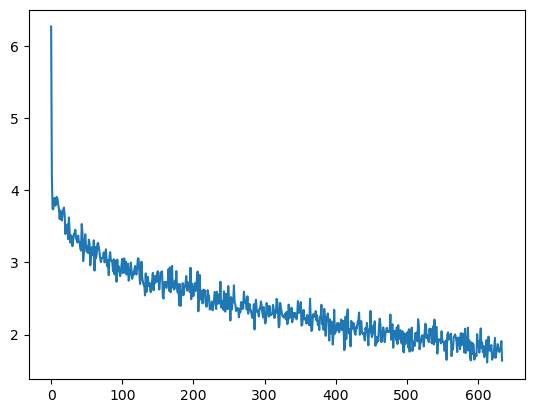

In [161]:
def Train_seq2seq():
    #获取数据
    train_dataloader = dm_test_MyPairsDataset()
    #实例化
   # train_dataloader = DataLoader(dataset = train_dataloader,batch_size = 1,shuffle = True)
    #实例化编码器对象
    input_size = english_word_n
    hidden_size = 256
    encoder = EncoderGRU(input_size,hidden_size).to(device)
    #实例化解码器
    output_size = french_word_n
    hidden_size = 256
    attn_decoder = AttnDecoderGRU(output_size,hidden_size).to(device)
    #实例化优化器对象
    encoder_adam = optim.Adam(encoder.parameters(),lr = mylr)
    decoder_adam = optim.Adam(attn_decoder.parameters(),lr = mylr)
    #实例化损失函数的对象
    cross_entroy = nn.NLLLoss()
    #定义存储损失的列表
    plot_loss_list = []
    #开启外部循环
    for epoch in range(1,epochs+1):
        #定义超参数
        print_loss_total,plot_loss_total = 0.0,0.0
        start_time = time.time()
        #开启内部循环
        for item,(x,y) in enumerate(tqdm(train_dataloader),start = 1):
            #开始调用内部迭代的函数
            my_loss = Train_Iters(x,y,encoder,attn_decoder,encoder_adam,decoder_adam,cross_entroy)
            print_loss_total += my_loss
            plot_loss_total += my_loss
            #打印损失
            if item % print_interval_num == 0:
                print_loss_avg = print_loss_total / print_interval_num
                #总损失变为0
                print_loss_total = 0
                print('轮次%d 损失%.6f 时间:%d' %(epoch,print_loss_avg,time.time() - start_time))
            #每隔100步保存平均损失
            if item % plot_interval_num == 0:
                plot_loss_avg = plot_loss_total / plot_interval_num
                plot_loss_list.append(plot_loss_avg)
                plot_loss_total = 0
            #print(x)
            #print(y)
            #break
        torch.save(encoder.state_dict(),'./seq2seq_encode_%d.pth'%epochs)
        torch.save(attn_decoder.state_dict(),'./seq2seq_decode_%d.pth'%epochs)
    #绘图
    plt.figure(0)
    plt.plot(plot_loss_list)
    plt.savefig('seq2seq_loss.png')
Train_seq2seq()

In [14]:
def seq2seq_evaluate(x,encoder_model,decoder_model):
    with torch.no_grad():
        #print('x',x.shape)
        h0 = encoder_model.inithidden()
        #[1,6,256] [1,1,256]
        encoder_output,encoder_hidden = encoder_model(x,h0)
        #进行解码器参数准备
        encoder_output_c = torch.zeros(MAX_LENGTH,encoder_model.hidden_size).to(device)
        #将真实的x编码后的结果赋值给encoder_output_c,其余为0
        for idx in range(encoder_output.shape[1]):
            encoder_output_c[idx] = encoder_output[0,idx]
        #print(encoder_output_c)
        #准备encoder_hidden代表解码器上一时间步的隐藏层输出 代表Key
        hidden = encoder_hidden
        #定义解码器的第一个字符SOS Q
        input_y = torch.tensor([[SOS_token]]).to(device)
        #定义存储解码出法文单词的列表
        decoded_list = []
        decoded_attention = torch.zeros(MAX_LENGTH,MAX_LENGTH)
        idx = 0
        for idx in range(MAX_LENGTH):
            output_y,hidden,attn_weights = decoder_model(input_y,hidden,encoder_output_c)
            #将每一步的权重进行复制
            decoded_attention[idx] = attn_weights
            topv,topi = torch.topk(output_y,k = 1)
            if topi.squeeze().item() == EOS_token:
                decoded_list.append('<EOS>')
                break#降维
            else:
                decoded_list.append(french_index2word[topi.item()])
            input_y = topi.detach()
        return decoded_list,decoded_attention[:idx+1]

In [15]:
#评估函数的应用
#准备好已经训练好的模型的路径
encoder_path = './seq2seq_encode_1.pth'
decoder_path = './seq2seq_decode_1.pth'
def use_evaluate():
    #实例化编码器对象 并且加载训练好的模型参数
    input_size = len(english_word2index)
    hidden_size = 256
    encoder_model = EncoderGRU(input_size,hidden_size).to(device)
    encoder_model.load_state_dict(torch.load(encoder_path))
    
    output_size = french_word_n
    decoder_model = AttnDecoderGRU(output_size,hidden_size).to(device)
    decoder_model.load_state_dict(torch.load(decoder_path))
    #准备预测的预料
    my_samplepairs =[['i m impressed with your french .', 'je suis impressionne par votre francais .'],
                     ['i m more than a friend .', 'je suis plus qu une amie .'],
                     ['she is beautiful like her mother .', 'elle est belle comme sa mere .']]
    print('my_samplepairs--->', len(my_samplepairs))
    #将遍历每个测试样本，将原始的英文句子送入模型得到预测结果并进行对比
    for item ,pair in enumerate(my_samplepairs):
        #print(pair)
        x = pair[0]#英文
        y = pair[1]#法文
        #x张量化
        temp_x = [english_word2index[word] for word in x.split(' ')]
        temp_x.append(EOS_token)
        tensor_x = torch.tensor(temp_x,dtype = torch.long).to(device).view(1,-1)
        #print('tensor_x',tensor_x.shape)
        decoded_word,attention = seq2seq_evaluate(tensor_x,encoder_model,decoder_model)
        predict_y = ' '.join(decoded_word)
        print("*"*80)
        print('<',x)
        print('=',y)
        print('>',predict_y)
        print("*"*80)
        #将张量化的x送入评估函数
use_evaluate()       

my_samplepairs---> 3
********************************************************************************
< i m impressed with your french .
= je suis impressionne par votre francais .
> je suis content de votre francais . <EOS>
********************************************************************************
********************************************************************************
< i m more than a friend .
= je suis plus qu une amie .
> je suis plus qu un ami . <EOS>
********************************************************************************
********************************************************************************
< she is beautiful like her mother .
= elle est belle comme sa mere .
> elle est belle comme sa mere . <EOS>
********************************************************************************


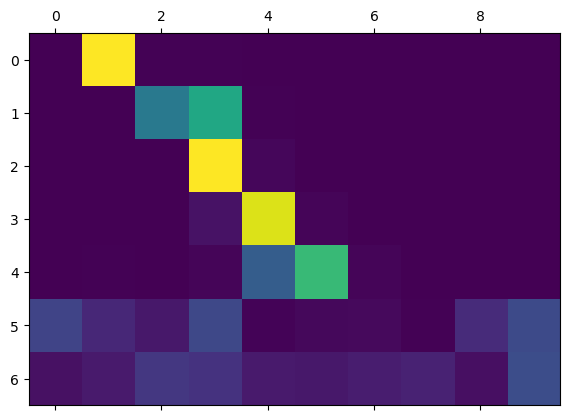

In [16]:
def test_attention_plot():
    input_size = len(english_word2index)
    hidden_size = 256
    encoder_model = EncoderGRU(input_size,hidden_size).to(device)
    encoder_model.load_state_dict(torch.load(encoder_path))
    
    output_size = french_word_n
    decoder_model = AttnDecoderGRU(output_size,hidden_size).to(device)
    decoder_model.load_state_dict(torch.load(decoder_path))
    sentence = "we re both teachers ."
    temp_x = [english_word2index[word] for word in sentence.split(' ')]
    temp_x.append(EOS_token)
    tensor_x = torch.tensor(temp_x,dtype = torch.long).to(device).view(1,-1)
    decoded_word,attention = seq2seq_evaluate(tensor_x,encoder_model,decoder_model)
    plt.matshow(attention.cpu().detach().numpy())
    plt.savefig('./ai19_attention.png')
    plt.show()
test_attention_plot()